<a href="https://colab.research.google.com/github/aish793/Data-Analytics/blob/main/Automobile_eCommerce_EDA_and_Predictive_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

Given Automobile eCommerce listing dataset containing 12 features and ~ 78k records.
- Goal 1 : Predict the `product_tier` which is the premium status of the article, from the information given in the other columns
- Goal 2 : Predict `detail_views` which is defined as the number of times the article has been clicked on, from the information given in the other columns

The solution is divided in following sections:
- Data Preparation
- Exploratory Data Analysis
- Setup Baseline
- Feature Engineering & Data Treatment
- Model Training & Model Comparison
- Conclusion
- Next Steps
- Additional Material

In [ ]:
# # Install dependencies
# !pip install xgboost
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib

In [ ]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('data/listingdata.csv', sep = ';')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78321 entries, 0 to 78320
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   article_id               78321 non-null  int64  
 1   product_tier             78321 non-null  object 
 2   make_name                78321 non-null  object 
 3   price                    78321 non-null  int64  
 4   first_zip_digit          78321 non-null  int64  
 5   first_registration_year  78321 non-null  int64  
 6   created_date             78321 non-null  object 
 7   deleted_date             78321 non-null  object 
 8   search_views             78311 non-null  float64
 9   detail_views             78311 non-null  float64
 10  stock_days               78321 non-null  int64  
 11  ctr                      78297 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 7.2+ MB


## Data Preparation

### 1. Data Type Conversion
- `ctr`: Convert from object to float64 for numerical operations.
- `created_date` and `deleted_date`: Convert from objects to datetime for date manipulations.
- `search_views` and `detail_views`: Downcast from float64 to int32 if they contain only integers to save memory.
- `first_registration_year`: Convert from int64 to datetime, retaining only the year for better date handling.

In [ ]:
data.first_registration_year = pd.to_datetime(data.first_registration_year, format='%Y').dt.year
data.created_date = pd.to_datetime(data.created_date, format="%d.%m.%y")
data.deleted_date = pd.to_datetime(data.deleted_date, format="%d.%m.%y")
data.deleted_date = pd.to_datetime(data.deleted_date, format="%d.%m.%y")

- `ctr, search_views, detail_views`: Missing values observed and should be treated prior to DType conversion

In [ ]:
# Sum of missing values per feature
print(data.isnull().sum())

# Additionally, let us also check if we have class imbalance in our dataset
data.product_tier.value_counts()

article_id                  0
product_tier                0
make_name                   0
price                       0
first_zip_digit             0
first_registration_year     0
created_date                0
deleted_date                0
search_views               10
detail_views               10
stock_days                  0
ctr                        24
dtype: int64


product_tier
Basic      75421
Premium     2324
Plus         576
Name: count, dtype: int64

In [ ]:
# Since we have class imbalance, we should be sure to not directly drop the missing records.
# We can create a subset of all the records/rows with missing values and observed their target label class.
missing_values_mask = data.isnull().any(axis=1)
data_missing_values = data[missing_values_mask]
data_missing_values.product_tier.value_counts()
data_missing_values.product_tier.value_counts()

product_tier
Basic    24
Name: count, dtype: int64

In [ ]:
# Since the missing records in the subset belong to the `Basic` label (majority class).
# We can simply drop them as it is only 0.03% from the entire dataset
data.dropna(inplace=True)

# We no longer have any missing values in the dataset and continue with out DType conversion
data.search_views = data.search_views.astype('int32')
data.detail_views = data.detail_views.astype('int32')

For DType conversion in `ctr` column --> an error was encountered due to the presence of erroneous values.
Let us remove them or we can also recompute them as `ctr` = `(detail_views/search_views)` as per the data description provided.

In [ ]:
# Define a regular expression pattern that resembles floating number pattern
valid_float_pattern = re.compile(r'^\d+(\.\d+)?$')
mask = data.ctr.apply(lambda row: valid_float_pattern.match(row))
total_errors = mask.isna().sum()
erroneous_record = data.ctr[mask.isna()]
print(f'{total_errors=}')
print(f'{erroneous_record=}')

total_errors=82
erroneous_record=849      27.624.309.392.265.100
1649      4.086.021.505.376.340
3885     30.066.815.144.766.100
4169      5.126.118.795.768.910
4410      1.485.148.514.851.480
                  ...          
71858     7.574.884.792.626.720
73055    23.525.280.898.876.400
73402     2.883.720.930.232.550
74868     4.199.855.177.407.670
76408    34.981.905.910.735.800
Name: ctr, Length: 82, dtype: object


In [ ]:
# Replace the erroneous values in the dataset with (detail_views/search_views)
error_index = data[mask.isnull()].index
data.loc[error_index, 'ctr'] = data.loc[error_index, 'detail_views'] / data.loc[error_index, 'search_views']

In [ ]:
# Convert the datatype of 'ctr'
data.ctr = data.ctr.astype('float')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78297 entries, 0 to 78320
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   article_id               78297 non-null  int64         
 1   product_tier             78297 non-null  object        
 2   make_name                78297 non-null  object        
 3   price                    78297 non-null  int64         
 4   first_zip_digit          78297 non-null  int64         
 5   first_registration_year  78297 non-null  int32         
 6   created_date             78297 non-null  datetime64[ns]
 7   deleted_date             78297 non-null  datetime64[ns]
 8   search_views             78297 non-null  int32         
 9   detail_views             78297 non-null  int32         
 10  stock_days               78297 non-null  int64         
 11  ctr                      78297 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int

Now we have all the desired DTypes for each feature and can move ahead with further data cleaning.

### 2. Data Cleaning
Let us check if our dataset has any further errors which might affect our EDA and model training.

In [ ]:
data.describe(include='all')

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
count,7.829700e+04,78297,78297,78297.000000,78297.000000,78297.000000,78297,78297,78297.00000,78297.000000,78297.000000,78297.000000
unique,NaN,3,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Basic,Volkswagen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,75397,9424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.574864e+08,NaN,NaN,15069.670358,4.631876,2011.090336,2018-09-17 15:14:38.792291072,2018-10-23 15:05:40.288899840,2297.91333,93.486583,35.995070,0.047957
min,3.472324e+08,NaN,NaN,50.000000,1.000000,1924.000000,2018-07-04 00:00:00,2018-07-04 00:00:00,1.00000,0.000000,-3.000000,0.000000
25%,3.536387e+08,NaN,NaN,5750.000000,3.000000,2008.000000,2018-08-08 00:00:00,2018-09-11 00:00:00,368.00000,13.000000,10.000000,0.024089
50%,3.585479e+08,NaN,NaN,10909.000000,5.000000,2013.000000,2018-09-20 00:00:00,2018-10-24 00:00:00,920.00000,36.000000,25.000000,0.037921
75%,3.614817e+08,NaN,NaN,18890.000000,7.000000,2015.000000,2018-10-24 00:00:00,2018-12-01 00:00:00,2234.00000,94.000000,55.000000,0.058200
max,3.647040e+08,NaN,NaN,249888.000000,9.000000,2106.000000,2018-11-28 00:00:00,2019-04-03 00:00:00,608754.00000,13926.000000,127.000000,87.500000


Observations from the above report:

- `stock_days` has values less than 0, which should be dropped as errors.
- `ctr` has a maximum value of 87.5, but since it represents `(detail_views/search_views)`, it should not exceed 1 and are human errors. Recompute errors as `(detail_views/search_views)`.
- `first_registration_year` has a maximum value of 2106, which is erroneous. It should not be greater than the current year.
- According to 'AS24_Data_Description.csv', `search_views` is the number of times the article appears in search results, and `detail_views` is the number of times it is clicked. `detail_views` should be less than or equal to `search_views`.

The following code removes these errors and cleans the data:

In [ ]:
prev_length = len(data)
data = data[data.stock_days >= 0]
data = data[data.detail_views <= data.search_views]
data = data[data.first_registration_year < 2025]

index_to_be_re_computed = data[data.ctr > 1].index
data.loc[index_to_be_re_computed, 'ctr'] = data.loc[index_to_be_re_computed, 'detail_views'] / data.loc[index_to_be_re_computed, 'search_views']
print(f'{data.shape=} \nNo. of Errors: {prev_length - len(data)}')

data.shape=(78203, 12) 
No. of Errors: 94


### 3. Drop Duplicate Records

In [ ]:
data.nunique()

article_id                 78187
product_tier                   3
make_name                     91
price                       5846
first_zip_digit                9
first_registration_year       86
created_date                  35
deleted_date                 273
search_views               10389
detail_views                1438
stock_days                   128
ctr                        47195
dtype: int64

By definition, `article_id` is defined as the unique article identifier. However, as shown above, there are only 78187 unique values out of a total of 78203 values. Hence, there exists duplicate values in `article_id`

In [ ]:
# Create a subset of duplicate 'article_id'
duplicate_article_ids_mask = data.duplicated(subset=['article_id'], keep=False)
duplicate_rows = data[duplicate_article_ids_mask]
print(f'{len(duplicate_rows)=}')

len(duplicate_rows)=32


We have 32 records which have duplicated `article_ids` so we can do the following
- Drop all of them
- Drop only one set of duplicates (preferred, to avoid any kind of data loss)

Let us look at the class labels of these duplicate records (assuming there should be a unique `product_tier` for each `article_id`). The idea is we look at the value counts and only drop `Basic` category (majority class) due to the class imbalance observed.

In [ ]:
duplicate_rows_by_product_tier = duplicate_rows.groupby(by='article_id')['product_tier'].unique()
duplicate_rows_by_product_tier.apply(sorted)

article_id
350214314    [Basic, Premium]
350214315    [Basic, Premium]
354755822       [Basic, Plus]
354755824       [Basic, Plus]
354755829       [Basic, Plus]
357528924    [Basic, Premium]
358519054       [Basic, Plus]
359772384       [Basic, Plus]
360472733    [Basic, Premium]
360768624    [Basic, Premium]
360768625    [Basic, Premium]
360768627    [Basic, Premium]
360768628    [Basic, Premium]
360768632    [Basic, Premium]
360793587    [Basic, Premium]
364638423    [Basic, Premium]
Name: product_tier, dtype: object

Analysis identifies 16 article_id entries with duplicates, resulting in a total of 32 duplicate entries. Each pair of duplicates includes one record with the Basic product_tier as indicated above. From a machine learning perspective, unique values are not essential, so the model can be trained without removing duplicates. However, assuming each article_id should be unique, we should retain only one copy of each article_id. To address the previously mentioned class imbalance issue, it is logical to remove the duplicates from the Basic product_tier, as it represents the majority class and this action will have minimal impact on the dataset.

In [ ]:
# Drop the 'Basic' product_tier duplicates
prev_length = len(data)
duplicate_rows_to_drop = duplicate_rows[duplicate_rows['product_tier'] == 'Basic'].index
data.drop(duplicate_rows_to_drop, inplace=True)
print(f'Records dropped: {prev_length - len(data)}')

Records dropped: 16


In [ ]:
# For building ML models unique identifier column is not required and thus it is safe to drop `article_id`
data.drop(columns='article_id', inplace=True)

### 4. Data validation

According to the data description provided, the columns are defined as `ctr = detail_views / search_views` and `stock_days = deleted_date - created_date`. We can take an additional step to ensure our dataset aligns closely with these definitions.

In [ ]:
expected_ctr= data['detail_views'] / data['search_views']
correct_ctr = np.isclose(data['ctr'], expected_ctr)
print(f'{correct_ctr.sum()=} | {len(data)=}')

expected_stock_days = (data.deleted_date - data.created_date).dt.days
correct_stock_days = np.isclose(data['stock_days'], expected_stock_days)
print(f'{correct_stock_days.sum()=} | {len(data)=}')
print(f'Shape of cleaned dataset: {data.shape}')

correct_ctr.sum()=66412 | len(data)=78187
correct_stock_days.sum()=66429 | len(data)=78187
Shape of cleaned dataset: (78187, 11)


From the analysis above, approximately 85% of the values in `stock_days` and `ctr` are correct. We will proceed with this understanding and address the observed deviations later. Ideally, this should be discussed and clarified with the stakeholders.

## Exploratory Data Analysis and Feature Engineering

### 1. Categorical feature encoding

As noted above, we have two object/categorical columns: `product_tier` and `make_name`. We will apply categorical encoding to `product_tier` and frequency encoding to `make_name`, given the high number of possible values within `make_name`.

Note: Since we have only 11 features and nearly 78,000 records, dimensionality reduction techniques are not yet necessary. We might need to perform some feature engineering later, such as one-hot encoding, feature extraction from date columns to capture seasonality factors, binning, etc. However, it makes sense to first get an initial impression of how our models perform without these additional steps.

In [ ]:
# use frequency encoder for `make_name` since they have ~90 possible values other encoding methods are not suitable here
freq_encoder = data.make_name.value_counts(normalize=True)
data.make_name = data.make_name.map(freq_encoder)
# Created own mapping for 'product_tier' (for Goal 1)
target_encoder = {'Basic': 0, 'Plus': 1, 'Premium': 2}
data.product_tier = data.product_tier.map(target_encoder)

### 2. Data Distributions

Let's examine the distribution of values for each feature and the target variable. To facilitate this, we can first define some reusable functions.

In [ ]:
def plot_histogram(data, col_names: list) -> None:
    num_cols, num_rows = 2, (len(col_names) + 1) // 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 5))

    axes = axes.flatten()
    for i, col_name in enumerate(col_names):
        mean, median, std = data[col_name].mean().round(2), data[col_name].median().round(2), data[col_name].std().round(2)
        percentile_99 = data[col_name].quantile(0.99).round(2)
        axes[i].hist(data[col_name], bins=20, color='skyblue', edgecolor='black')
        axes[i].set_xlabel(col_name)
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'mean={mean} | median={median} | std={std} | percentile_99={percentile_99}')

    plt.tight_layout()
    plt.show()

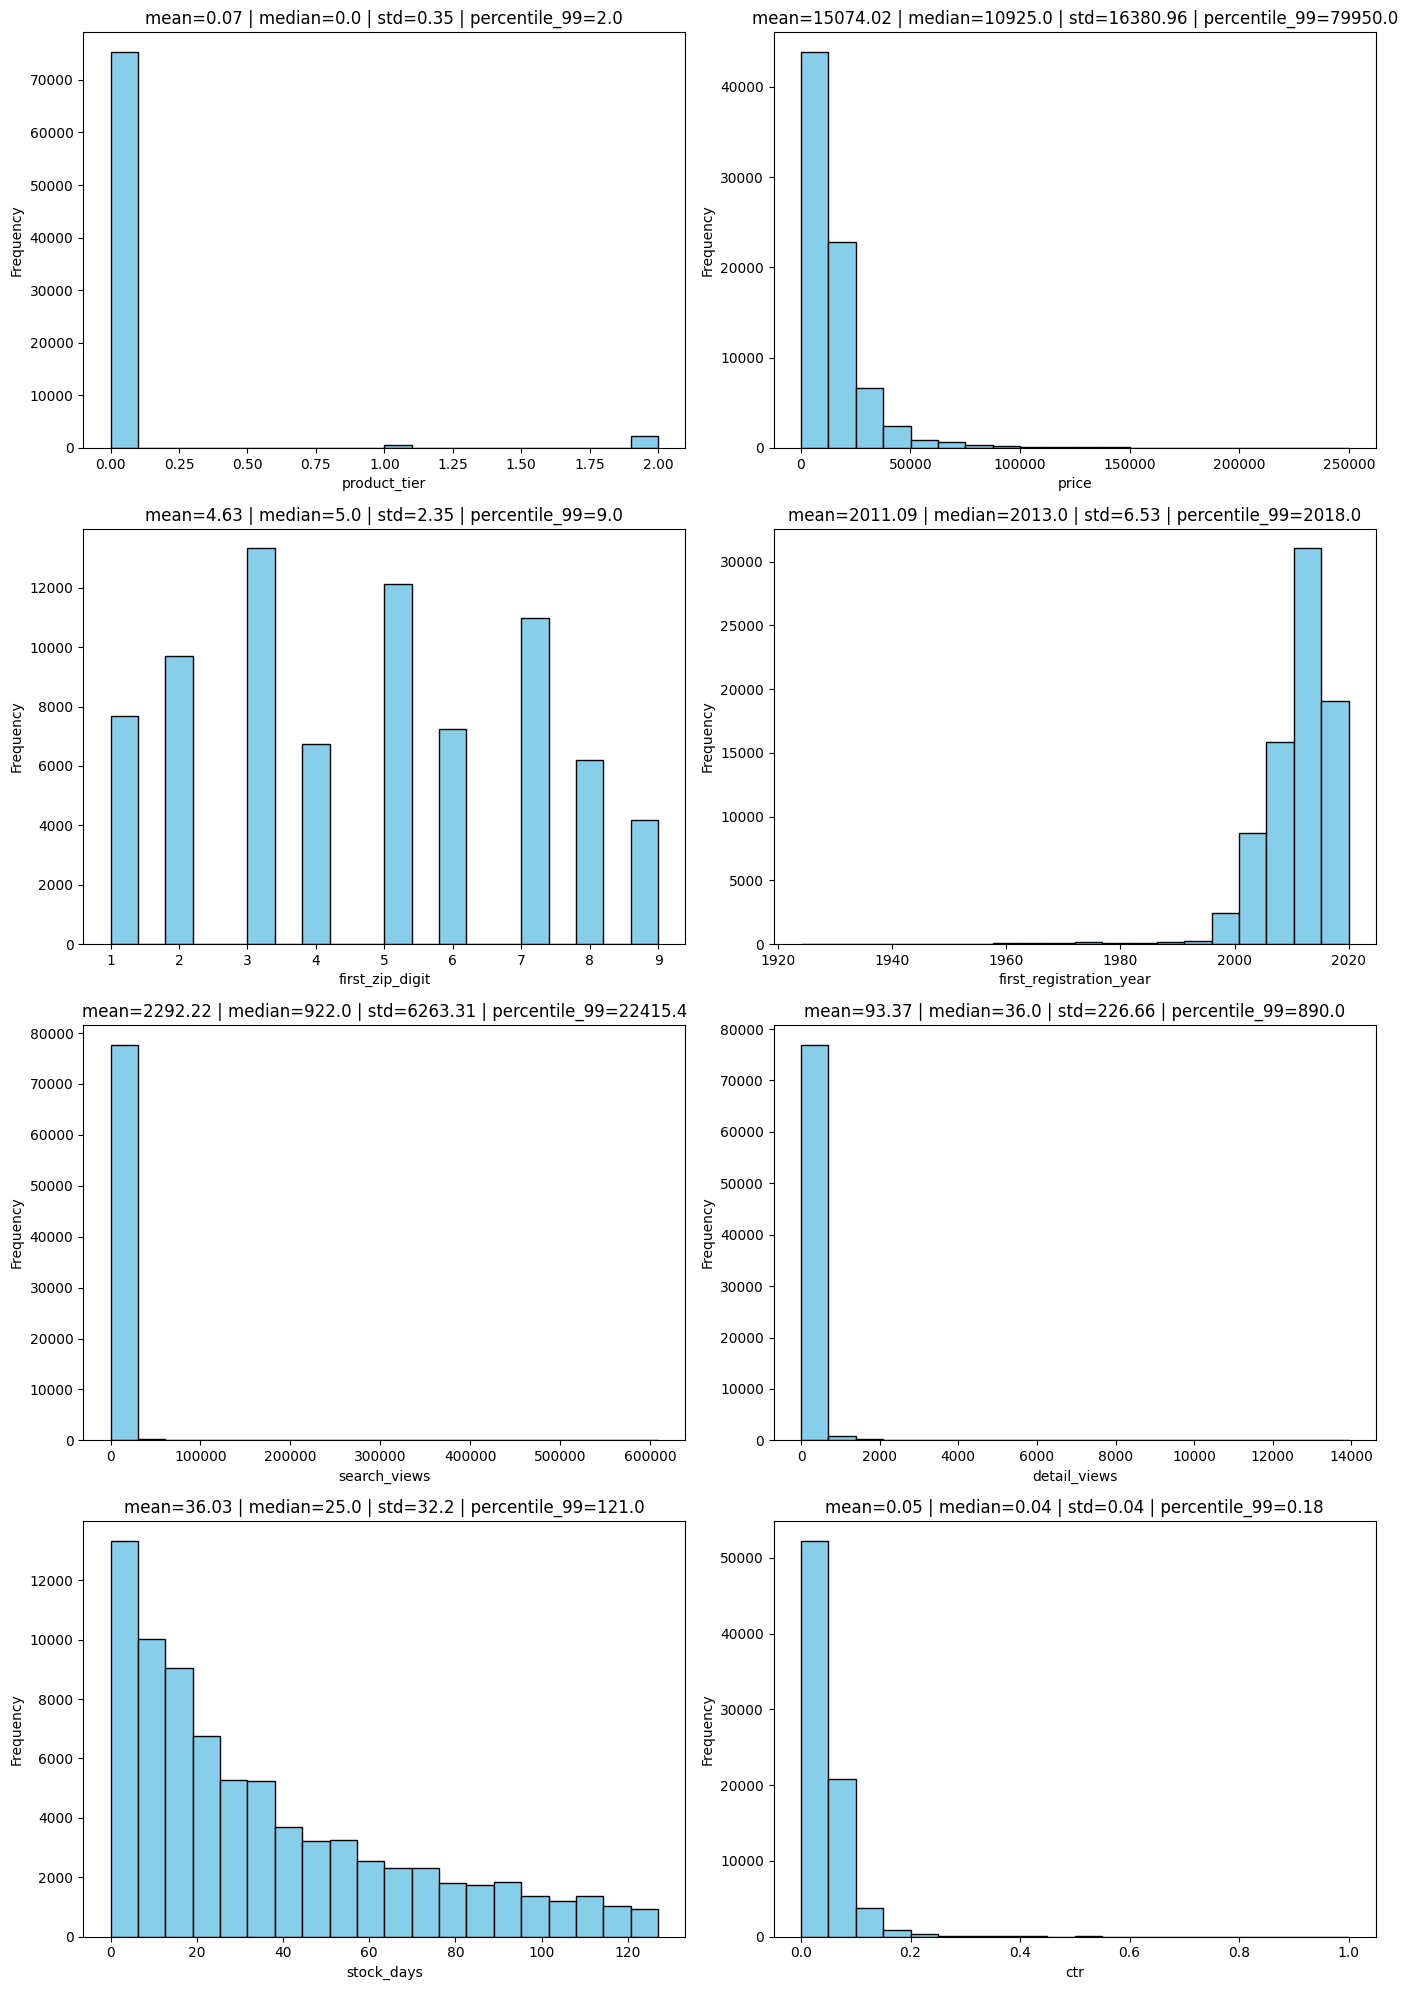

In [ ]:
columns_to_plot = [
    'product_tier', 'price', 'first_zip_digit', 'first_registration_year',
    'search_views', 'detail_views', 'stock_days', 'ctr'
]

plot_histogram(data, columns_to_plot)

Observations from the feature data distributions:

- `price`, `search_views`, `detail_views`, `stock_days`, and `ctr` exhibit right-skewed distributions, whereas `first_registration_year` shows a left-skewed distribution.
- The 99th percentile value for `price` is 79,950, yet the maximum value reaches approximately 250,000, indicating the presence of outliers.
- The 99th percentile value for `search_views` is 22,415.4, but the maximum value is around 600,000, suggesting the presence of outliers.
- The 99th percentile value for `detail_views` is 890, yet the maximum value goes up to about 14,000, indicating outliers.
- `stock_days` does not have outliers, as both the 99th percentile value and the maximum value are 121.
- `ctr` shows some outliers, with the 99th percentile value at 0.18 and a maximum value of up to 1.
- `first_registration_year` indicates outliers for older registered cars, with the 99th percentile value at 2018.

### 3. Correlation Heatmaps

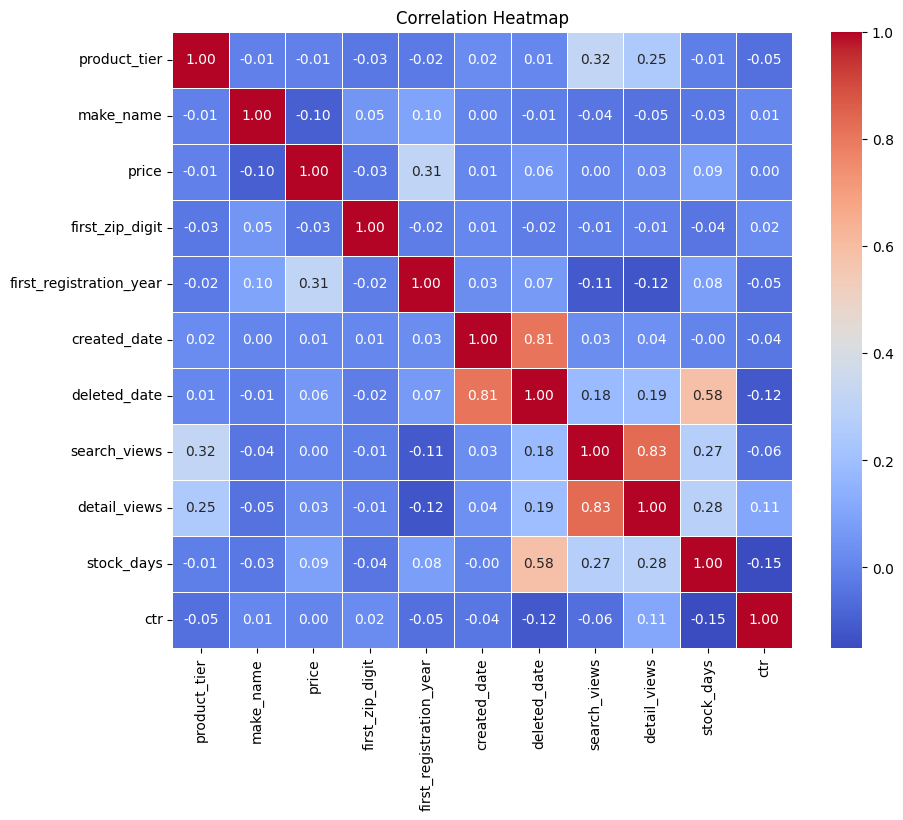

,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
product_tier,1.000000,-0.007251,-0.007712,-0.029905,-0.024046,0.021600,0.010660,0.320117,0.246508,-0.011697,-0.052971
make_name,-0.007251,1.000000,-0.095974,0.053619,0.101041,0.004295,-0.014864,-0.037582,-0.046554,-0.031341,0.008782
price,-0.007712,-0.095974,1.000000,-0.034063,0.311845,0.011373,0.059402,0.003804,0.029616,0.085730,0.004137
first_zip_digit,-0.029905,0.053619,-0.034063,1.000000,-0.016658,0.008417,-0.016112,-0.010667,-0.007336,-0.039158,0.021142
first_registration_year,-0.024046,0.101041,0.311845,-0.016658,1.000000,0.027197,0.069976,-0.111123,-0.123128,0.081890,-0.053702
created_date,0.021600,0.004295,0.011373,0.008417,0.027197,1.000000,0.810641,0.026936,0.035969,-0.000715,-0.035140
deleted_date,0.010660,-0.014864,0.059402,-0.016112,0.069976,0.810641,1.000000,0.181652,0.194178,0.584915,-0.116106
search_views,0.320117,-0.037582,0.003804,-0.010667,-0.111123,0.026936,0.181652,1.000000,0.833549,0.272863,-0.058761
detail_views,0.246508,-0.046554,0.029616,-0.007336,-0.123128,0.035969,0.194178,0.833549,1.000000,0.281771,0.106427
stock_days,-0.011697,-0.031341,0.085730,-0.039158,0.081890,-0.000715,0.584915,0.272863,0.281771,1.000000,-0.149608


In [ ]:
def compute_plot_corr(data) -> np.array:
    corr_matrix = data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()
    return corr_matrix

compute_plot_corr(data)

#### a. EDA Summary

- **Correlation Matrix**:
    - Only `search_views` and `detail_views` and `deleted_date` and `created_date` show high correlation.
    - `product_tier` is loosely correlated with `search_views` and `detail_views`.
    - `deleted_date` and `stock_days` also show correlation.
    - There is no strong correlation in the dataset, which may indicate a lack of variance/pattern. This should be further evaluated based on how our ML models perform against the evaluation metrics.

- **Label Distributions**:
    - There are 3 categories in `product_tier`. The `Basic` category is the majority class, while `premium` and `plus` are minority classes, indicating a class imbalance in the dataset.

- **Feature Distributions**:
    - No feature in the dataset is normally distributed.
    - There are outliers in the dataset that need to be addressed. However, due to the class imbalance, we want to avoid data loss and will refrain from outlier treatment until the initial ML model training is complete.

#### b. Feature Engineering
We will do this later after we have set our baselines. This can better guide us on how/if to change anything with the features

## Setup Baseline

We have two goals:

- **Goal 1**: Use `Random Forest` as our initial baseline.
- **Goal 2**: Use `Linear Regression` as our initial baseline.

Each goal requires a unique set of features and labels: for the first set, `product_tier` will be the target label, and for the second set, `detail_views` will be the target.

To accomplish this efficiently, let's define some helper functions that can provide these feature and target sets as numpy arrays. We will also use these functions to evaluate our ML models.

In [ ]:
# Let us create a backup of our original dataset.
data_backup = data.copy()

# As date columns cannot be directly interpreted by the ML models we need to drop them.
data.drop(columns=['created_date', 'deleted_date'], inplace=True)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

def create_feature_set(target_column, stratify_flag=True):

    feature_columns = list(set(data.columns) - set([target_column]))

    features, targets = data[feature_columns].values, data[target_column].values
    if stratify_flag:
        X_train, X_test, y_train, y_test = train_test_split(
            features, targets, test_size=0.2, random_state=42, stratify=targets
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            features, targets, test_size=0.2, random_state=42
        )

    return feature_columns, X_train, X_test, y_train, y_test

def evaluate_classifier(y_test, y_pred, classifier):

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test Accuracy: {accuracy:.2f}')

    precision_per_class = precision_score(y_test, y_pred, average=None, labels=classifier.classes_)
    recall_per_class = recall_score(y_test, y_pred, average=None, labels=classifier.classes_)
    f1_per_class = f1_score(y_test, y_pred, average=None, labels=classifier.classes_)

    # Compute cumulative (macro-averaged) precision and recall
    precision_macro = precision_score(y_test, y_pred, average='macro')  # todo: study f1-macro
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    # Print precision, recall, and F1 score for each class
    for i, label in enumerate(classifier.classes_):
        print(
            f'Class {label}: Precision = {precision_per_class[i]:.2f}, Recall = {recall_per_class[i]:.2f}, F1 Score = {f1_per_class[i]:.2f}')

    # Print cumulative (macro-averaged) precision, recall, and F1 score
    print(f'Cumulative Precision (Macro-Averaged): {precision_macro:.2f}')
    print(f'Cumulative Recall (Macro-Averaged): {recall_macro:.2f}')
    print(f'Cumulative F1 Score (Macro-Averaged): {f1_macro:.2f}')


def plot_confusion_matrix(y_test, y_pred, classifier):

    cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {str(classifier)[:15]}')
    plt.show()

### 1. Evaluating basline ML classifier (Random Forest)
The baseline model demonstrates good accuracy with the Random Forest classifier. However, due to the class imbalance in the dataset, accuracy might not be the most reliable metric. Therefore, we will use precision, recall, and F1-score to better assess the performance of the classifiers.

Training accuracy:  1.0
Test Accuracy: 0.97
Class 0: Precision = 0.97, Recall = 1.00, F1 Score = 0.98
Class 1: Precision = 0.00, Recall = 0.00, F1 Score = 0.00
Class 2: Precision = 0.76, Recall = 0.34, F1 Score = 0.47
Cumulative Precision (Macro-Averaged): 0.58
Cumulative Recall (Macro-Averaged): 0.45
Cumulative F1 Score (Macro-Averaged): 0.49


/Users/ajsharma/anaconda3/envs/AutoScout24/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ajsharma/anaconda3/envs/AutoScout24/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


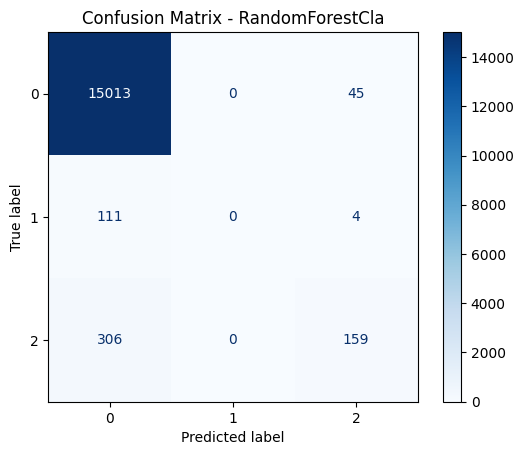

In [ ]:
def train_evaluate_random_forest(x_train, x_test, y_train, y_test):
    # Initialize a Random Forest using `sklearn`
    from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier(class_weight='balanced', random_state=42)
    rfc.fit(x_train, y_train)
    print('Training accuracy: ', rfc.score(x_train, y_train))
    y_pred = rfc.predict(x_test)

    evaluate_classifier(y_test, y_pred, rfc)
    plot_confusion_matrix(y_test, y_pred, rfc)

# Feature Set 1
feature_columns, x_train, x_test, y_train, y_test = create_feature_set(target_column='product_tier')
train_evaluate_random_forest(x_train, x_test, y_train, y_test)

**Problems**:

Class 1 (minority class) has very low precision, recall, and F1 score, indicating severe issues in predicting this class. The model fails to capture instances of this class effectively.
The cumulative recall (macro-averaged) is relatively low, indicating that the model misses a considerable number of positive instances across all classes. This suggests a general problem with the model's ability to identify instances of all classes accurately.

**Note**: While GridSearchCV was applied, it didn't notably enhance the results. Further details on its implementation are available in the supplementary material, which we won't delve into presently but can revisit later if required.

### 2. Evaluating basline ML regressor (Linear regression)

In [ ]:
def train_evaluate_linear_regression(x_train, x_test, y_train, y_test):
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    feature_scaler = StandardScaler()
    x_train_scaled = feature_scaler.fit_transform(x_train)
    x_test_scaled = feature_scaler.transform(x_test)
    model = LinearRegression()
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)

    # mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Absolute Error: {mae}')
    print(f'R-squared: {r2}')
    # print('Coefficients:', model.coef_)
    # print('Intercept:', model.intercept_)

# Feature Set 2
feature_columns, x_train, x_test, y_train, y_test = create_feature_set(target_column='detail_views', stratify_flag=False)
train_evaluate_linear_regression(x_train, x_test, y_train, y_test)

Mean Absolute Error: 37.974354149415234
R-squared: 0.7325793950104491


The baseline linear regression model attained an R-squared value of 0.787, suggesting that around 78.7% of the variance in the target variable (detail_views) is accounted for by the model. To capture more variance, we will explore alternative regression models, and feature engineering.

In the subsequent sections, we will refine our feature engineering and address outliers

## Feature Engineering and Outlier Treatment

For the next few sections, our focus will solely be on Goal 1, aiming to comprehend the low performance of the random forest model. Several factors may contribute to this, as outlined below:

- Omitting the date columns `created_date` and `deleted_date` could lead to missing valuable information. Enhancing our analysis by incorporating new features derived from these dates, such as the day of the week, weekend status, or day of the year, could be beneficial.
- The `first_zip_code` column is currently treated as ordinal, although it should be considered nominal. Employing one-hot encoding to represent these categories might improve our evaluation metrics.

We will commence with the `dates` and `first_zip_code` columns, as they hold promise for feature engineering.

Furthermore, feature engineering might not yield significant benefits for columns like `first_registration_year`, `search_views`, `detail_views`, `stock_days`, and `ctr`. `product_tier` and `make_name` are already adequately engineered or offer limited scope for further enhancement.

#### 1. Mofifying date columns

In [ ]:
def feature_engineer_date_columns(data):
    data['created_date_day'] = data.created_date.dt.day
    data['created_date_day_of_week'] = data.created_date.dt.day_of_week
    data['created_date_is_weekend'] = data.created_date.dt.day_of_week > 5
    data['created_date_day_of_year'] = data.created_date.dt.dayofyear

    data['deleted_date_day'] = data.deleted_date.dt.day
    data['deleted_date_day_of_week'] = data.deleted_date.dt.day_of_week
    data['deleted_date_is_weekend'] = data.deleted_date.dt.day_of_week > 5
    data['deleted_date_day_of_year'] = data.deleted_date.dt.dayofyear

    # As date columns cannot be directly interpreted by the Ml models we need to drop them.
    # Also, we don't want to bring correlation by keeping both of them.
    data.drop(columns=['created_date', 'deleted_date'], inplace=True)
    return data

# Let us use our data_backup to do modify the feature engineering step
data = data_backup.copy()
data = feature_engineer_date_columns(data)

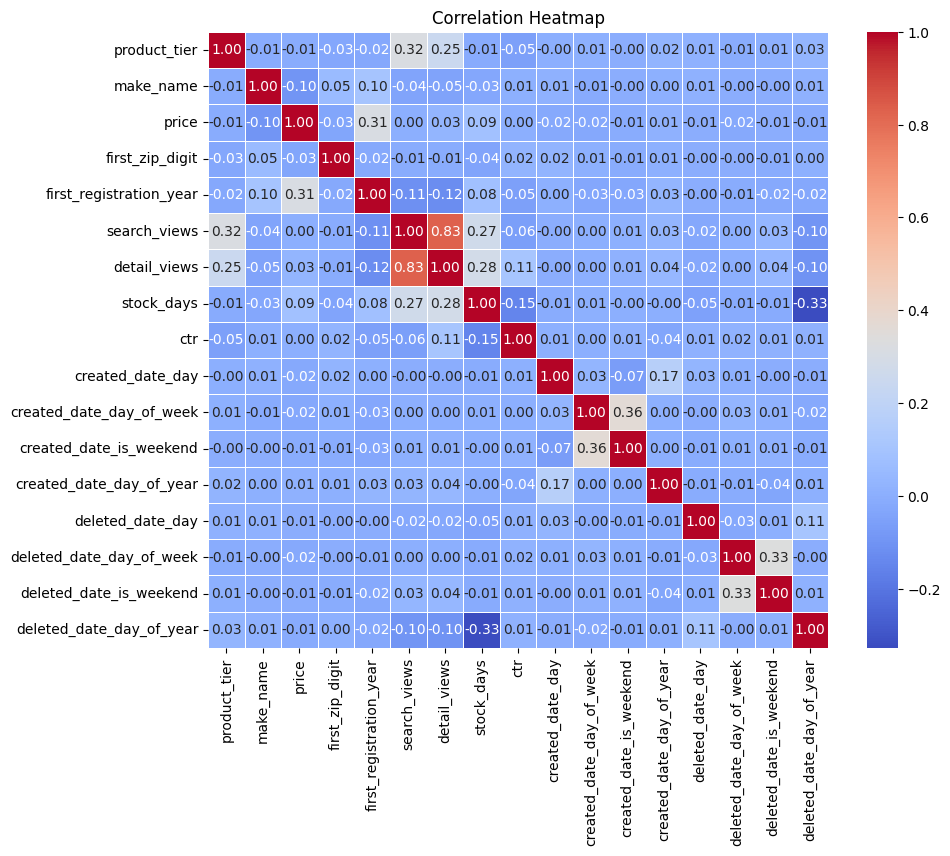

,product_tier,make_name,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days,ctr,created_date_day,created_date_day_of_week,created_date_is_weekend,created_date_day_of_year,deleted_date_day,deleted_date_day_of_week,deleted_date_is_weekend,deleted_date_day_of_year
product_tier,1.000000,-0.007251,-0.007712,-0.029905,-0.024046,0.320117,0.246508,-0.011697,-0.052971,-0.000008,0.007857,-0.003901,0.021600,0.011541,-0.007877,0.006387,0.025753
make_name,-0.007251,1.000000,-0.095974,0.053619,0.101041,-0.037582,-0.046554,-0.031341,0.008782,0.013625,-0.014184,-0.003322,0.004295,0.010939,-0.004041,-0.003683,0.012539
price,-0.007712,-0.095974,1.000000,-0.034063,0.311845,0.003804,0.029616,0.085730,0.004137,-0.020360,-0.023805,-0.008016,0.011373,-0.005692,-0.020430,-0.005734,-0.011974
first_zip_digit,-0.029905,0.053619,-0.034063,1.000000,-0.016658,-0.010667,-0.007336,-0.039158,0.021142,0.020183,0.005963,-0.008121,0.008417,-0.003159,-0.003787,-0.011201,0.004485
first_registration_year,-0.024046,0.101041,0.311845,-0.016658,1.000000,-0.111123,-0.123128,0.081890,-0.053702,0.004669,-0.027023,-0.028450,0.027197,-0.004904,-0.007094,-0.020330,-0.022916
search_views,0.320117,-0.037582,0.003804,-0.010667,-0.111123,1.000000,0.833549,0.272863,-0.058761,-0.002854,0.003031,0.005204,0.026936,-0.021915,0.003080,0.031132,-0.098815
detail_views,0.246508,-0.046554,0.029616,-0.007336,-0.123128,0.833549,1.000000,0.281771,0.106427,-0.001229,0.001705,0.012733,0.035969,-0.023042,0.002031,0.036087,-0.101909
stock_days,-0.011697,-0.031341,0.085730,-0.039158,0.081890,0.272863,0.281771,1.000000,-0.149608,-0.010569,0.005497,-0.000080,-0.000715,-0.048681,-0.011643,-0.014192,-0.327660
ctr,-0.052971,0.008782,0.004137,0.021142,-0.053702,-0.058761,0.106427,-0.149608,1.000000,0.005390,0.000062,0.011877,-0.035140,0.011132,0.015699,0.010501,0.012106
created_date_day,-0.000008,0.013625,-0.020360,0.020183,0.004669,-0.002854,-0.001229,-0.010569,0.005390,1.000000,0.026087,-0.067853,0.167782,0.025937,0.005835,-0.003142,-0.005323


In [ ]:
# Let us visualise the correlation heatmap once again to check if we have any variance introduced as part of feature engineering the date columns.
compute_plot_corr(data)

Initial observation from the heatmap above: There doesn't appear to be any notable enhancement in terms of correlation between features or feature-target sets. However, this isn't a definitive indicator of whether this feature engineering step should proceed. Let's retrain and reassess our classifier once more.

Training accuracy:  0.9999840125341732
Test Accuracy: 0.97
Class 0: Precision = 0.97, Recall = 1.00, F1 Score = 0.98
Class 1: Precision = 1.00, Recall = 0.01, F1 Score = 0.02
Class 2: Precision = 0.80, Recall = 0.30, F1 Score = 0.43
Cumulative Precision (Macro-Averaged): 0.92
Cumulative Recall (Macro-Averaged): 0.43
Cumulative F1 Score (Macro-Averaged): 0.48


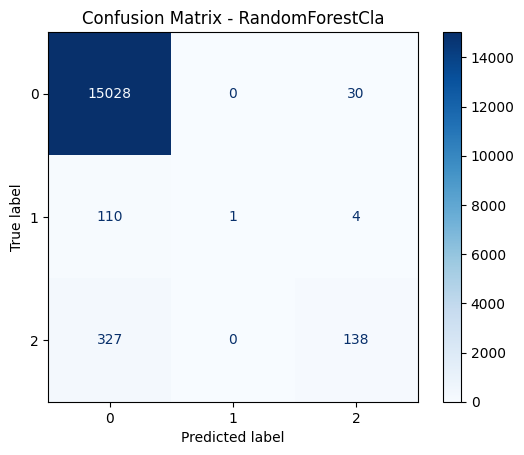

In [ ]:
# Let's train our model again check if there were any improvements
feature_columns, x_train, x_test, y_train, y_test = create_feature_set(target_column='product_tier')
train_evaluate_random_forest(x_train, x_test, y_train, y_test)

We continue to observe no substantial improvement in the evaluation scores. Let's proceed to try the alternative feature engineering approach with the zip codes.

#### 2. Modifying zip_code columns

Training accuracy:  1.0
Test Accuracy: 0.97
Class 0: Precision = 0.97, Recall = 1.00, F1 Score = 0.99
Class 1: Precision = 0.00, Recall = 0.00, F1 Score = 0.00
Class 2: Precision = 0.81, Recall = 0.33, F1 Score = 0.47
Cumulative Precision (Macro-Averaged): 0.59
Cumulative Recall (Macro-Averaged): 0.44
Cumulative F1 Score (Macro-Averaged): 0.48


/Users/ajsharma/anaconda3/envs/AutoScout24/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ajsharma/anaconda3/envs/AutoScout24/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


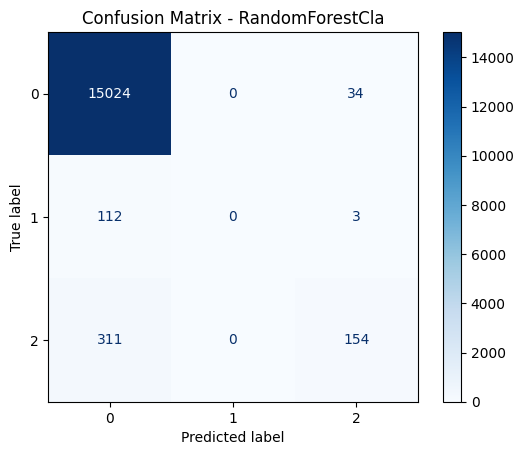

In [ ]:
def _one_hot_encode_zip_code(data):
    encoded_df = pd.get_dummies(data['first_zip_digit'], drop_first=True, dtype=int)
    data = pd.concat([data, encoded_df], axis=1)
    data.drop(columns=['first_zip_digit'], inplace=True)
    return data

# Let us use our data_backup to do modify the feature engineering step
data = data_backup.copy()
# Since we just concluded  that `date` columns do not add any advantage to our test scores, it can be dropped.
data.drop(columns=['created_date', 'deleted_date'], inplace=True)

data = _one_hot_encode_zip_code(data)
# Feature Set 1
feature_columns, x_train, x_test, y_train, y_test = create_feature_set(target_column='product_tier')
train_evaluate_random_forest(x_train, x_test, y_train, y_test)

Similar observation: No significant improvement noted.

Several other methods were attempted, but no substantial improvement was observed:

1. Oversampling of minority samples using SMOTE:
```python
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)
```

2. Using class weights in the classifier.

Observation: Despite the attempts, there was no enhancement in the scores.

#### 3. Plausible Reasons for the low f1-score

There could be several reasons why we haven't observed improvements in our metric scores:

- Binning operation for the target label: Merging the "Plus" and "Premium" categories into a single "Plus" category. Note: This applies only to Goal 1 (To predict product_tier).

- Noise samples in the "Basic" category: Outliers in the subset of data with "Basic" as the target label may confuse the model when classifying test samples. One potential approach to address this is to perform partial outlier treatment, specifically removing outliers (values > 99th percentile) only from the "Basic" category. The aim is to maintain the number of samples in our minority class.

Let's proceed to implement these steps methodically.

#### 4. Binning

To start, we'll combine the target labels "Plus" and "Premium" into a unified category, "Plus," due to the relatively small number of records. This merging process aims to support our classifiers in effectively delineating the decision boundary, especially when training samples are limited. By consolidating "Plus" and "Premium" into a single class, we enhance the representation of this collective category, potentially offering our classifiers more robust training data and improved generalization capabilities.

In [ ]:
data = data_backup.copy()
data.product_tier = data.product_tier.replace(2, 1)
data.product_tier.value_counts()

product_tier
0    75287
1     2900
Name: count, dtype: int64

Above, 0 represents the class `Basic` (which is the majority class) and 1 reprsents the class `plus` (`plus` and `premium` binned and is a minority class)

#### 5. Remove outliers from feature columns

Next, we're implementing a data treatment strategy to remove noisy samples from our majority class. In this context, a noisy sample (outlier) within the majority class subset is one that doesn't fall within the 99th percentile of the data values for that class. Instead, it exhibits characteristics more typical of the opposite class label. This situation arises when outliers in the majority class are closer to the mean of the minority class and fall within the 99th percentile value of the minority class. Consequently, the model becomes confused, especially when encountering large values (considered outliers for the majority class). As a result, it may incorrectly classify these outliers as belonging to the minority class, hindering the creation of a clear decision boundary. For instance, when examining the histogram plots for the `search_views` column, we observe that the 99th percentile value for the majority class is around 15000. However, upon inspecting the histogram of the minority class for this feature, we find that 15000 is relatively close to the mean of the minority class subset.

In [ ]:
basic_data = data[data.product_tier == 0]  # 0 == Basic
non_basic_data = data[data.product_tier != 0]

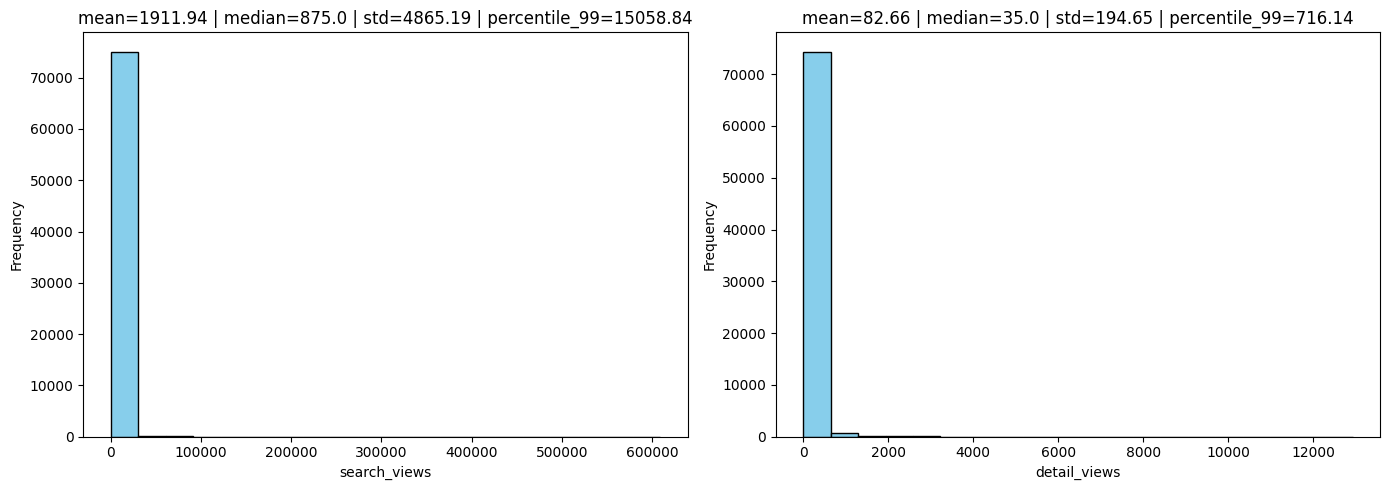

In [ ]:
# Plot 'search_views' histogram for majority class (Basic)
columns_to_plot = ['search_views', 'detail_views']
plot_histogram(basic_data, columns_to_plot)

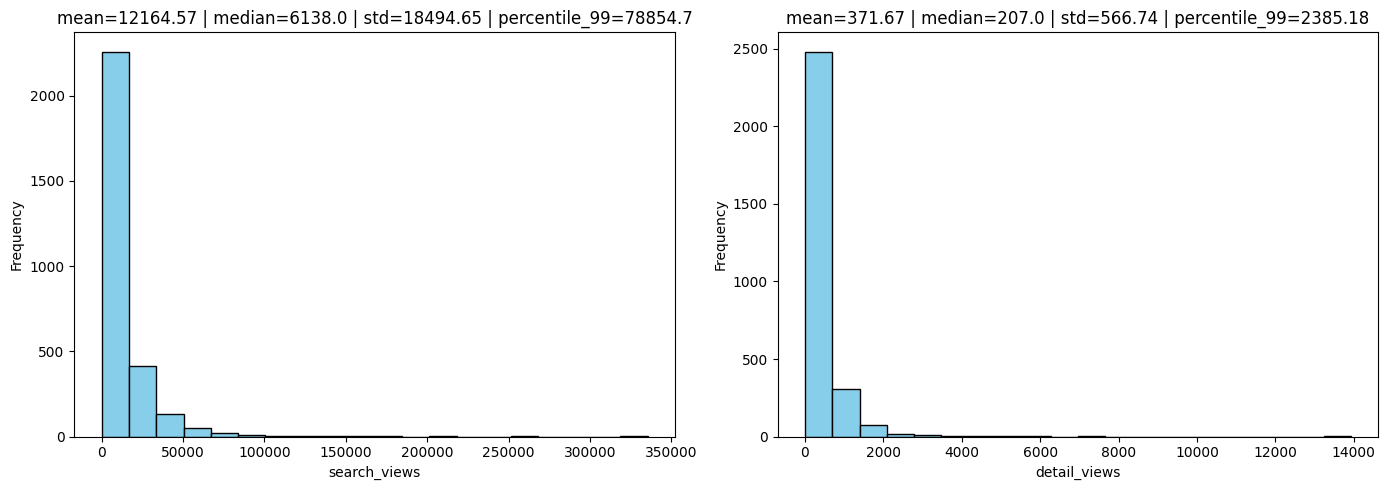

In [ ]:
plot_histogram(non_basic_data, columns_to_plot)

If we observe from above histograms, 99 percent of records with `Basic` category are showing a median of 875 that means the 1% of the values is not really a representative of the majority class subset but somehwere might be confusing the classifier. The confusion will be created becuase a higher value in `search_views` is actually a trait of the `plus` and `premium` category dataset. So we can afford to remove these 1% noisy samples and is a data treatment technique.

We can observe the same for `detail_views`

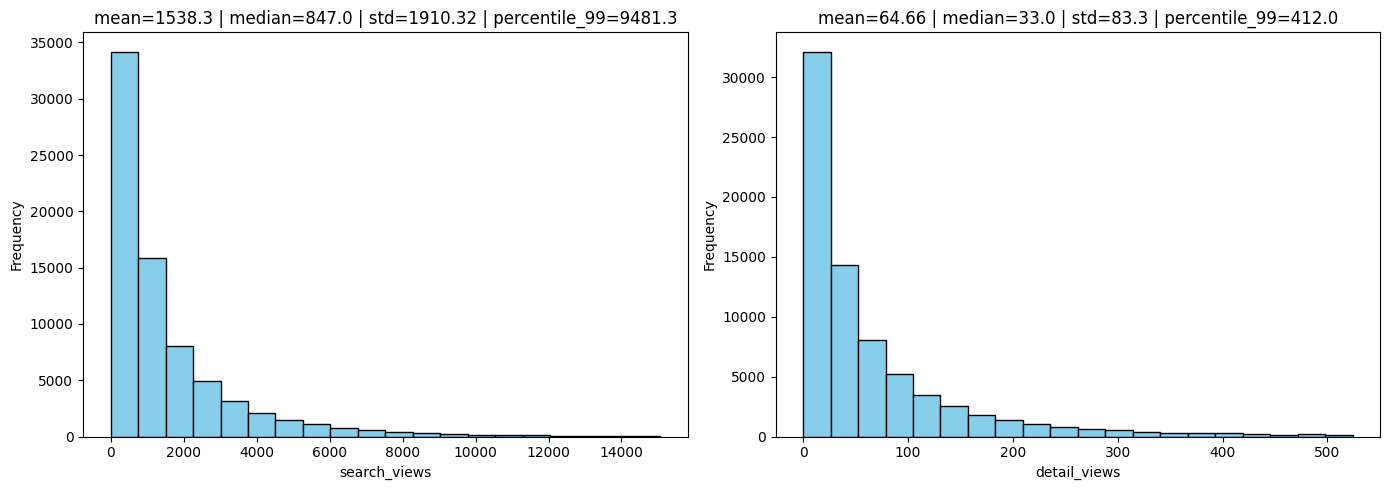

In [ ]:
# ONLY remove outliers from the majority class subset (Basic class)
basic_data = basic_data[basic_data.search_views < basic_data.search_views.quantile(0.99)]
basic_data = basic_data[basic_data.detail_views < basic_data.detail_views.quantile(0.99)]
plot_histogram(basic_data, columns_to_plot)

We can see an improvement in the data distribution for the above two columns and will use them for our model training. these outliers have been removed and account for <1% of the entire dataset.

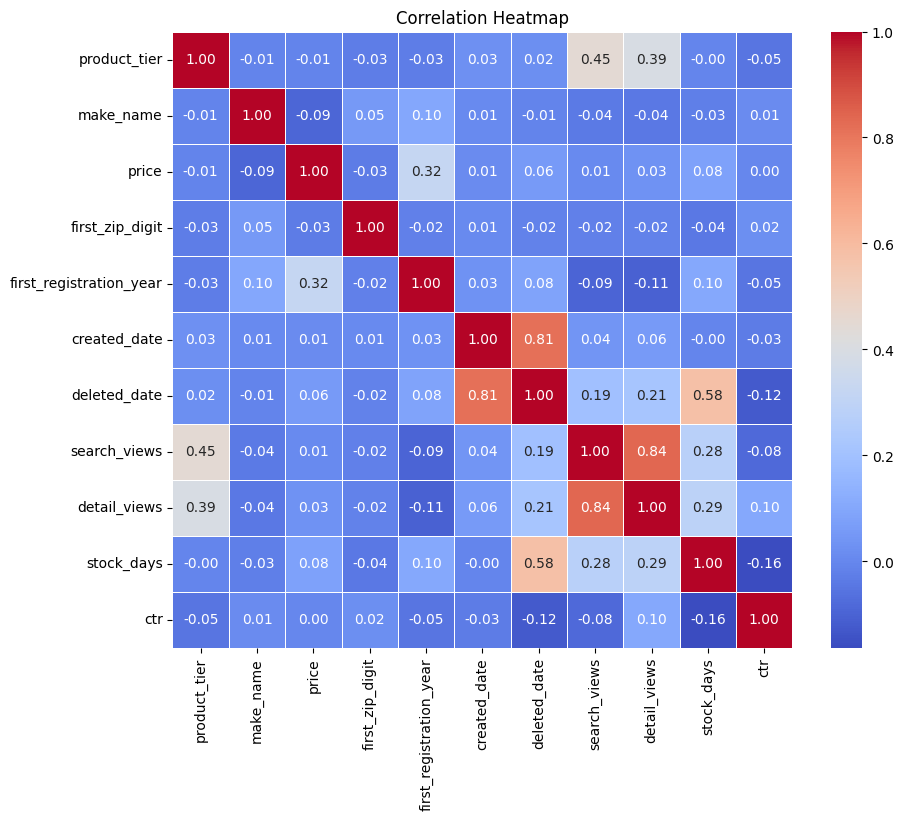

,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
product_tier,1.000000,-0.009267,-0.009340,-0.026888,-0.030173,0.026760,0.019294,0.447134,0.392620,-0.004383,-0.051082
make_name,-0.009267,1.000000,-0.092408,0.054441,0.097539,0.006349,-0.009634,-0.037387,-0.044386,-0.025527,0.010940
price,-0.009340,-0.092408,1.000000,-0.034026,0.321372,0.011863,0.057149,0.006375,0.030410,0.081767,0.000565
first_zip_digit,-0.026888,0.054441,-0.034026,1.000000,-0.017770,0.008453,-0.017019,-0.020123,-0.015872,-0.041164,0.021577
first_registration_year,-0.030173,0.097539,0.321372,-0.017770,1.000000,0.029773,0.083183,-0.094650,-0.105558,0.101415,-0.052948
created_date,0.026760,0.006349,0.011863,0.008453,0.029773,1.000000,0.814052,0.038013,0.056610,-0.003762,-0.034471
deleted_date,0.019294,-0.009634,0.057149,-0.017019,0.083183,0.814052,1.000000,0.192383,0.214363,0.577675,-0.122575
search_views,0.447134,-0.037387,0.006375,-0.020123,-0.094650,0.038013,0.192383,1.000000,0.838855,0.277810,-0.081794
detail_views,0.392620,-0.044386,0.030410,-0.015872,-0.105558,0.056610,0.214363,0.838855,1.000000,0.289533,0.101157
stock_days,-0.004383,-0.025527,0.081767,-0.041164,0.101415,-0.003762,0.577675,0.277810,0.289533,1.000000,-0.162597


In [ ]:
data = pd.concat([basic_data, non_basic_data], axis=0)
# Now let us look at the correlation heatmap once again.
compute_plot_corr(data)

#### 6. Summary

If we compare it to our initial correlation heatmap, we observe a slight improvement.
Therefore, Initial hypothesis: ML models will tend to show a higher performance when there is some variance observed in the dataset as a result of removing the noisy samples(outliers) from `Basic` product tier category.

Let us validate this hypothesis.

**Note:** Other columns did not have this mismatch of data distributions in both these subsets, and were not treated by outlier removal.
We are doing this as a part of data treatment and check if our evaluation scores improve.

## ML Model Training and Comparison

### 1. Random Forest

Training accuracy:  0.9999836995501076
Test Accuracy: 0.98
Class 0: Precision = 0.98, Recall = 1.00, F1 Score = 0.99
Class 1: Precision = 0.93, Recall = 0.42, F1 Score = 0.58
Cumulative Precision (Macro-Averaged): 0.95
Cumulative Recall (Macro-Averaged): 0.71
Cumulative F1 Score (Macro-Averaged): 0.78


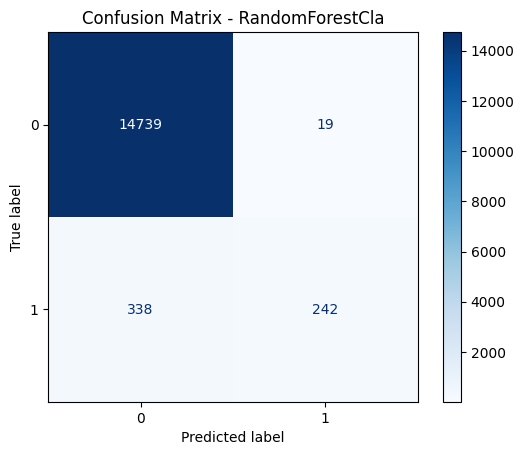

In [ ]:
# Since we concluded `date` columns to not add any advantage to our test scores, it can be dropped.
data.drop(columns=['created_date', 'deleted_date'], inplace=True)

# Feature Set 1
feature_columns, x_train, x_test, y_train, y_test = create_feature_set(target_column='product_tier')
train_evaluate_random_forest(x_train, x_test, y_train, y_test)

As we can see from the results above, there is a significant improvement in our test scores. Now, let us do the same for `Goal 2`

### 2. Linear Regression

In [ ]:
# Feature Set 2
feature_columns, x_train, x_test, y_train, y_test = create_feature_set(target_column='detail_views', stratify_flag=False)
train_evaluate_linear_regression(x_train, x_test, y_train, y_test)

Mean Absolute Error: 28.770582670409873
R-squared: 0.7859398198508138


The MAE value dropped from ~37 to ~28. The R-squared value also increased to 0.785, meaning that the model is able to capture ~78% variance in the target variable

### 3. XGBoost Classifier

Now, let's deploy additional models to assess their performance compared to the baselines. To expedite the process, I've opted to initially focus solely on a boosting technique. However, alternative options such as Naive Bayes, neural networks, and SVMs can also be evaluated for comparison.

Training accuracy:  0.9893721066701441
Test Accuracy: 0.98
Class 0: Precision = 0.98, Recall = 1.00, F1 Score = 0.99
Class 1: Precision = 0.84, Recall = 0.53, F1 Score = 0.65
Cumulative Precision (Macro-Averaged): 0.91
Cumulative Recall (Macro-Averaged): 0.76
Cumulative F1 Score (Macro-Averaged): 0.82


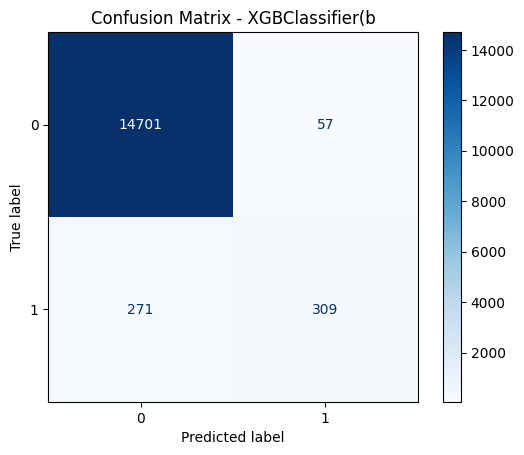

In [ ]:
# For Goal 1: Predicting product_tier
def train_evaluate_xgboostclassifier(x_train, x_test, y_train, y_test):
    import xgboost as xgb
    from xgboost import XGBClassifier
    xgbc = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgbc.fit(x_train, y_train)
    print('Training accuracy: ', xgbc.score(x_train, y_train))
    y_pred = xgbc.predict(x_test)

    evaluate_classifier(y_test, y_pred, xgbc)
    plot_confusion_matrix(y_test, y_pred, xgbc)

# Feature Set 1
feature_columns, x_train, x_test, y_train, y_test = create_feature_set(target_column='product_tier')
train_evaluate_xgboostclassifier(x_train, x_test, y_train, y_test)

As we can see from the above results, XGBoost classifier gives a better precision, recall and f1-score as compared to the random forest classifier. As XGBoost uses gradient boosting which builds trees sequentially with every new tree correcting errors made by the previous tree, this can be one of the many possible reasons for a better performance of the XGBoost classifier.

In [ ]:
# For Goal 2: Predicting detail_views

feature_columns, x_train, x_test, y_train, y_test = create_feature_set(target_column='detail_views', stratify_flag=False)
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

feature_scaler = StandardScaler()
x_train_scaled = feature_scaler.fit_transform(x_train)
x_test_scaled = feature_scaler.transform(x_test)
model = XGBRegressor(objective='reg:squarederror')
model.fit(x_train_scaled, y_train)

# Make predictions
y_pred = model.predict(x_test_scaled)

# Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Absolute Error: 4.9827381593630875
R-squared: 0.8437925577163696


As we can see above, there has been a significant improvement in the R-squared value to 0.84 meaning that this model is able to capture ~84% variance in the data. The MAE has also significantly reduced as compared to linear regression.

## Final Results / Conclusion

- We prepared the dataset by changing data types, removing missing records, addressing errors in feature columns, and performing validation checks. Despite the validation not being an exact match, we assumed all values were correct for this challenge.
- We encoded categorical data for our classifiers to interpret them as numerical values. We also analyzed data distributions and correlation heatmaps to identify any patterns.
- We established a baseline to determine suitable feature engineering steps. Initially, the models performed poorly for the minority class and were biased towards predicting the "Basic" class labels.
- To address this, we binned the target label and treated outliers in the majority class subset, which proved beneficial for subsequent steps.
- During model training, we observed significant improvement in evaluation metrics, with the XGBoost classifier showing the best performance so far.

## Next Steps

Considering limited information about the features and minority representation for `Premium` and `Plus`. I would have following as my next steps if there is more time

- Perform GridSearch to find the best parameters for model traininig
- K-fold cross validation
- Explore more classifiers, regressors like Naive Bayes', SVM, Neural Nets (they did not make as my first choice yet given the dataaset)
- Explore data distributions with some clustering algorithms to justify/identify the noise/outlier treatment done above
- Some more effort in the exploratory data analysis with meaningful plots and statistics.

### Additional Material

Fine Tuning (if there is time)


In [ ]:

def dt_param_search(features, targets):
    classifier = DecisionTreeClassifier()
    param_grid = {
        'max_depth': [2, 4, 6, 8],
        'splitter': ['best', 'random'],
        'min_samples_leaf': [2, 4, 6, 8],
        'min_samples_split': [2, 4, 6, 8],
        'criterion': ['gini', 'entropy'],
        'random_state': [0, 42]}

    # GridSearchCV object
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')

    # Fitting the model
    grid.fit(features, targets)

    # Best parameters
    print('Best parameters: ', grid.best_params_)
    return grid.best_params_


def rf_param_search(features, targets):
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier(random_state=42)
    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4]
    }

    # GridSearchCV object
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')

    # Fitting the model
    grid.fit(features, targets)

    # Best parameters
    print(f'Best parameters found: {grid.best_params_}')
    print(f'Best F1 score: {grid.best_score_:.2f}')
    return grid.best_params_

#### Feature distributions - Feature wise histogram distribution         

In [ ]:
# # All feature distributions observed were skewed and thus IQR is an appropriate measure to identify outliers
# def identify_outliers_skewed_distribution(col_name: str,
#                                           lower_bound: float = 0.25,
#                                           upper_bound: float = 0.99) -> pd.Series:
#     lower_bound, upper_bound = data[col_name].quantile(lower_bound), data[col_name].quantile(upper_bound)
#     iqr = upper_bound - lower_bound
#     data_below_lower_bound = lower_bound - 1.5 * iqr
#     data_above_upper_bound = upper_bound + 1.5 * iqr

#     outlier_mask = ((data[col_name] < data_below_lower_bound) | (data[col_name] > data_above_upper_bound))

#     print(f'{outlier_mask.sum() / len(data) * 100} % are outliers')
#     print(f'{outlier_mask.sum()}')
#     return outlier_mask


#maybe not required at all